## Import Libraries

In [ ]:
!pip install catboost
!pip install pytorch-tabnet
!pip install ydata-profiling

In [2]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder, RobustScaler
from pytorch_tabnet.pretraining import TabNetPretrainer
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from catboost import CatBoostRegressor, Pool
from ydata_profiling import ProfileReport
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from google.colab import drive


import matplotlib.pyplot as plt
import lightgbm as lgb
import seaborn as sns
import pandas as pd
import numpy as np
import torch

## Mount Drive

In [3]:
drive.mount('/content/drive/')

Mounted at /content/drive/


## Load and Merge Data

In [4]:
input_features = pd.read_csv('/content/drive/MyDrive/poverty_data/train_hh_features.csv')
input_labels = pd.read_csv('/content/drive/MyDrive/poverty_data/train_hh_gt.csv')
submission_features = pd.read_csv('/content/drive/MyDrive/poverty_data/test_hh.csv')

print(f"Input features shape: {input_features.shape}")
print(f"Input labels shape: {input_labels.shape}")

# Merge features and labels for training
input_df = input_features.merge(input_labels, on=['hhid', 'survey_id'])

print(f"Input shape: {input_df.shape}")
print(f"Submission shape: {submission_features.shape}")

Input features shape: (104234, 88)
Input labels shape: (104234, 3)
Input shape: (104234, 89)
Submission shape: (103023, 88)


## Data Analysis

In [ ]:
profile = ProfileReport(input_df, title="Profiling Report")
profile

## Create X,y values (drop IDs from X)

In [6]:
target_col = 'cons_ppp17'
id_cols = ['survey_id', 'hhid']

columns_to_drop = id_cols + [target_col]

X = input_df.drop(columns=columns_to_drop)
y = input_df[target_col]

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")


Shape of X: (104234, 86)
Shape of y: (104234,)


## Train - Test Split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Extract weights
train_original_weights = X_train['weight'].copy()
test_original_weights = X_test['weight'].copy()

print(f"Shape of X_train_initial_df: {X_train.shape}")
print(f"Shape of X_test_initial_df: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")
print(f"Shape of train_original_weights: {train_original_weights.shape}")

Shape of X_train_initial_df: (83387, 86)
Shape of X_test_initial_df: (20847, 86)
Shape of y_train: (83387,)
Shape of y_test: (20847,)
Shape of train_original_weights: (83387,)


## Preprocess Data (Replace Missing Values and Encoding)

In [8]:
features = [c for c in input_features.columns if c not in id_cols]

num_cols = input_features[features].select_dtypes(include=['number']).columns.tolist()
cat_cols = input_features[features].select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Numerical features: {len(num_cols)}")
print(f"Categorical features: {len(cat_cols)}")

Numerical features: 22
Categorical features: 64


In [9]:
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", RobustScaler())
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipeline, num_cols),
        ("cat", cat_pipeline, cat_cols),
    ]
)

In [10]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"Shape of X_train_processed: {X_train_processed.shape}")
print(f"Shape of X_test_processed: {X_test_processed.shape}")

Shape of X_train_processed: (83387, 182)
Shape of X_test_processed: (20847, 182)


## Set Up for Training and Evaluation

In [11]:
weight_idx = num_cols.index('weight')

print(f"The 'weight' column is at index {weight_idx} within the numerical features after preprocessing. This index should be used when dropping 'weight' from preprocessed arrays.")

The 'weight' column is at index 1 within the numerical features after preprocessing. This index should be used when dropping 'weight' from preprocessed arrays.


In [12]:
def calculate_wmape(y_true, y_pred, weights):
    ape = np.abs((y_true - y_pred) / y_true)
    return np.average(ape, weights=weights)

# Setup Target (Log Transform)
y_log_train = np.log1p(y_train)
y_log_test = np.log1p(y_test)

# Remove 'weight' from the Training Features and Test Features
X_train_fit = np.delete(X_train_processed, weight_idx, axis=1)
X_test_fit = np.delete(X_test_processed, weight_idx, axis=1)

## Baseline Model (Random Forest)

In [13]:
# Train the Model on the full training data
print("Training Baseline Random Forest...")
model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
model.fit(X_train_fit, y_log_train)

# Evaluate with wMAPE on the held-out Test set
test_preds_log = model.predict(X_test_fit)
test_preds = np.expm1(test_preds_log)
y_test_orig = np.expm1(y_log_test)

w_mape_test = calculate_wmape(y_test_orig, test_preds, test_original_weights) # Use original test weights

print(f"Test wMAPE: {w_mape_test:.4f}")

print("Predictions for X_test are ready.")

Training Baseline Random Forest...
Test wMAPE: 0.3064
Predictions for X_test are ready.


In [14]:
print(test_preds.shape)

(20847,)


## LightGBM


In [15]:
# Instantiate an LGBMRegressor model
model_lgbm = lgb.LGBMRegressor(
    n_estimators=500,
    max_depth=10,
    random_state=42,
    n_jobs=-1,
    verbose = -1
)


# Get the number of features
num_features = X_train_fit.shape[1]
# Create generic column names
col_names = [f'feature_{i}' for i in range(num_features)]

X_train_df = pd.DataFrame(X_train_fit, columns=col_names)
X_test_df = pd.DataFrame(X_test_fit, columns=col_names)


# Train the LightGBM model on the full training data
print("Training LightGBM Regressor...")
model_lgbm.fit(X_train_df, y_log_train, sample_weight = train_original_weights)

# Evaluate on Train Set
train_preds_lgbm_log = model_lgbm.predict(X_train_df)
train_preds_lgbm = np.expm1(train_preds_lgbm_log)

# Evaluate with wMAPE on the held-out Test set
test_preds_lgbm_log = model_lgbm.predict(X_test_df)
test_preds_lgbm = np.expm1(test_preds_lgbm_log)

w_mape_train_lgbm = calculate_wmape(y_train, train_preds_lgbm, train_original_weights)
w_mape_test_lgbm = calculate_wmape(y_test_orig, test_preds_lgbm, test_original_weights)

print(f"LightGBM Train wMAPE: {w_mape_train_lgbm:.4f}")
print(f"LightGBM Test wMAPE: {w_mape_test_lgbm:.4f}")
print("Predictions for X_test using LightGBM are ready.")

Training LightGBM Regressor...
LightGBM Train wMAPE: 0.2102
LightGBM Test wMAPE: 0.2669
Predictions for X_test using LightGBM are ready.


In [16]:
print(f"Random Forest Test wMAPE: {w_mape_test:.4f}")
print(f"LightGBM Test wMAPE: {w_mape_test_lgbm:.4f}")

Random Forest Test wMAPE: 0.3064
LightGBM Test wMAPE: 0.2669


## CatBoost

In [17]:
# Ensure OrdinalEncoder outputs integers
cat_pipeline_cb = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, dtype=int))
])

preprocessor_cb = ColumnTransformer(
    transformers=[
        ("num", num_pipeline, num_cols), # num_cols come first
        ("cat", cat_pipeline_cb, cat_cols), # cat_cols come after
    ]
)

print("Επεξεργασία δεδομένων για CatBoost...")
X_train_processed_array = preprocessor_cb.fit_transform(X_train)
X_test_processed_array = preprocessor_cb.transform(X_test)

# We will use generic names for categorical features to avoid name collisions if any.
num_feature_names_out = num_cols
cat_feature_names_out = [f"cat_encoded_{i}" for i in range(len(cat_cols))]

all_processed_feature_names = num_feature_names_out + cat_feature_names_out

# Convert the processed NumPy arrays to Pandas DataFrames
X_train_df_cb = pd.DataFrame(X_train_processed_array, columns=all_processed_feature_names, index=X_train.index)
X_test_df_cb = pd.DataFrame(X_test_processed_array, columns=all_processed_feature_names, index=X_test.index)

# Although OrdinalEncoder has dtype=int, ColumnTransformer might cast everything to float due to numerical features.
for col_name in cat_feature_names_out:
    X_train_df_cb[col_name] = X_train_df_cb[col_name].astype(int)
    X_test_df_cb[col_name] = X_test_df_cb[col_name].astype(int)

# Remove the 'weight' column from the DataFrames
weight_col_name = 'weight' # Assuming 'weight' is in num_cols and thus present in X_train_df_cb
X_train_fit_cb = X_train_df_cb.drop(columns=[weight_col_name])
X_test_fit_cb = X_test_df_cb.drop(columns=[weight_col_name])

# Identify categorical features by their names in the final DataFrame for CatBoost
cat_features_in_final_df = [col for col in cat_feature_names_out if col in X_train_fit_cb.columns]
cat_indices = [X_train_fit_cb.columns.get_loc(col) for col in cat_features_in_final_df]



print("\nTraining CatBoost Regressor...")

model_cb = CatBoostRegressor(
    iterations=6000,
    learning_rate=0.05,
    depth=8,
    loss_function='MAE',
    eval_metric='MAE',
    random_seed=42,
    verbose=200,
    allow_writing_files=False
)

# Now passing DataFrames to Pool
train_pool = Pool(
    data=X_train_fit_cb,
    label=y_log_train,
    cat_features=cat_indices, # Pass indices
    weight=train_original_weights
)

test_pool = Pool(
    data=X_test_fit_cb,
    cat_features=cat_indices
)

model_cb.fit(train_pool)

test_preds_cb_log = model_cb.predict(test_pool)
test_preds_cb = np.expm1(test_preds_cb_log)

w_mape_test_cb = calculate_wmape(y_test_orig, test_preds_cb, test_original_weights)
print(f"\nCatBoost Test wMAPE: {w_mape_test_cb:.4f}")

Επεξεργασία δεδομένων για CatBoost...

Training CatBoost Regressor...
0:	learn: 0.4571319	total: 206ms	remaining: 20m 37s
200:	learn: 0.2469646	total: 23.9s	remaining: 11m 28s
400:	learn: 0.2185079	total: 52.1s	remaining: 12m 7s
600:	learn: 0.2093441	total: 1m 21s	remaining: 12m 7s
800:	learn: 0.2052654	total: 1m 50s	remaining: 12m
1000:	learn: 0.2024628	total: 2m 20s	remaining: 11m 39s
1200:	learn: 0.2000597	total: 2m 48s	remaining: 11m 14s
1400:	learn: 0.1980893	total: 3m 16s	remaining: 10m 46s
1600:	learn: 0.1961457	total: 3m 44s	remaining: 10m 17s
1800:	learn: 0.1948097	total: 4m 12s	remaining: 9m 49s
2000:	learn: 0.1935636	total: 4m 40s	remaining: 9m 21s
2200:	learn: 0.1921796	total: 5m 8s	remaining: 8m 52s
2400:	learn: 0.1910084	total: 5m 36s	remaining: 8m 24s
2600:	learn: 0.1900914	total: 6m 4s	remaining: 7m 55s
2800:	learn: 0.1891353	total: 6m 34s	remaining: 7m 30s
3000:	learn: 0.1880986	total: 7m 3s	remaining: 7m 3s
3200:	learn: 0.1872375	total: 7m 32s	remaining: 6m 35s
3400:	

## Ensemble Method

In [18]:
best_alpha = 0
min_wmape = float('inf')

for a in np.linspace(0, 1, 11):
    current_preds = (a * test_preds_cb) + ((1 - a) * test_preds_lgbm)
    score = calculate_wmape(y_test_orig, current_preds, test_original_weights)
    print(f"Weight Alpha {a:.1f}: wMAPE = {score:.4f}")

    if score < min_wmape:
        min_wmape = score
        best_alpha = a

print(f"\nΤο καλύτερο Alpha είναι το {best_alpha:.1f} με wMAPE: {min_wmape:.4f}")

Weight Alpha 0.0: wMAPE = 0.2669
Weight Alpha 0.1: wMAPE = 0.2654
Weight Alpha 0.2: wMAPE = 0.2641
Weight Alpha 0.3: wMAPE = 0.2630
Weight Alpha 0.4: wMAPE = 0.2621
Weight Alpha 0.5: wMAPE = 0.2614
Weight Alpha 0.6: wMAPE = 0.2609
Weight Alpha 0.7: wMAPE = 0.2606
Weight Alpha 0.8: wMAPE = 0.2605
Weight Alpha 0.9: wMAPE = 0.2606
Weight Alpha 1.0: wMAPE = 0.2609

Το καλύτερο Alpha είναι το 0.8 με wMAPE: 0.2605


In [19]:
alpha = best_alpha
final_ensemble_preds = (alpha * test_preds_cb) + ((1 - alpha) * test_preds_lgbm)

# 4. Υπολογισμός του νέου wMAPE
ensemble_wmape = calculate_wmape(y_test_orig, final_ensemble_preds, test_original_weights)

print(f"LightGBM wMAPE: {w_mape_test_lgbm:.4f}")
print(f"CatBoost wMAPE: {w_mape_test_cb:.4f}")
print("-" * 30)
print(f"Ensemble wMAPE (70/30): {ensemble_wmape:.4f}")

LightGBM wMAPE: 0.2669
CatBoost wMAPE: 0.2609
------------------------------
Ensemble wMAPE (70/30): 0.2605


## Deep Learning Model

In [20]:
from sklearn.preprocessing import QuantileTransformer


num_pipeline_tabnet = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", QuantileTransformer(output_distribution='normal', random_state=42))
])


cat_pipeline_tabnet = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

preprocessor_tabnet = ColumnTransformer(
    transformers=[
        ("num", num_pipeline_tabnet, num_cols),
        ("cat", cat_pipeline_tabnet, cat_cols),
    ]
)


X_train_tab = preprocessor_tabnet.fit_transform(X_train)
X_test_tab = preprocessor_tabnet.transform(X_test)

weight_idx_tab = num_cols.index('weight')
X_train_tab = np.delete(X_train_tab, weight_idx_tab, axis=1)
X_test_tab = np.delete(X_test_tab, weight_idx_tab, axis=1)

In [21]:
num_features_count = len(num_cols) - 1
cat_idxs = list(range(num_features_count, num_features_count + len(cat_cols)))
cat_dims = [int(input_df[col].nunique() + 1) for col in cat_cols]


tabnet_params = dict(
    n_d=32, n_a=32,
    n_steps=5,
    gamma=1.3,
    lambda_sparse=0,
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=10,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='entmax',
    device_name='auto'
)


tabnet_reg = TabNetRegressor(**tabnet_params)

tabnet_reg.fit(
    X_train=X_train_tab,
    y_train=y_log_train.values.reshape(-1, 1),
    eval_set=[(X_test_tab, y_log_test.values.reshape(-1, 1))],
    eval_name=['test'],
    eval_metric=['mae'],
    max_epochs=200,
    patience=20,
    batch_size=1024,
    virtual_batch_size=128,
    weights=train_original_weights,
)


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.87995 | test_mae: 0.34943 |  0:00:07s
epoch 1  | loss: 0.14491 | test_mae: 0.30383 |  0:00:14s
epoch 2  | loss: 0.125   | test_mae: 0.28551 |  0:00:20s
epoch 3  | loss: 0.11555 | test_mae: 0.27706 |  0:00:26s
epoch 4  | loss: 0.1115  | test_mae: 0.27931 |  0:00:32s
epoch 5  | loss: 0.10202 | test_mae: 0.26797 |  0:00:39s
epoch 6  | loss: 0.09815 | test_mae: 0.26124 |  0:00:45s
epoch 7  | loss: 0.09784 | test_mae: 0.25978 |  0:00:52s
epoch 8  | loss: 0.09508 | test_mae: 0.25786 |  0:00:58s
epoch 9  | loss: 0.09623 | test_mae: 0.25318 |  0:01:05s
epoch 10 | loss: 0.09385 | test_mae: 0.25683 |  0:01:12s
epoch 11 | loss: 0.0926  | test_mae: 0.26117 |  0:01:19s
epoch 12 | loss: 0.09322 | test_mae: 0.25694 |  0:01:26s
epoch 13 | loss: 0.09129 | test_mae: 0.26047 |  0:01:34s
epoch 14 | loss: 0.08985 | test_mae: 0.25106 |  0:01:40s
epoch 15 | loss: 0.08997 | test_mae: 0.25513 |  0:01:47s
epoch 16 | loss: 0.08705 | test_mae: 0.25034 |  0:01:53s
epoch 17 | loss: 0.08689 | test

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [22]:
preds_tabnet_log = tabnet_reg.predict(X_test_tab)
preds_tabnet = np.expm1(preds_tabnet_log).flatten()

# Calculate wMAPE for train and test, ensuring correct y_true
tabnet_wmape = calculate_wmape(y_test_orig, preds_tabnet, test_original_weights)

print(f"\nTabNet Test wMAPE: {tabnet_wmape:.4f}")


TabNet Test wMAPE: 0.2753


## Model Performance Comparison (wMAPE)

/tmp/ipython-input-4065781111.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='wMAPE', data=comparison_df, palette='viridis')


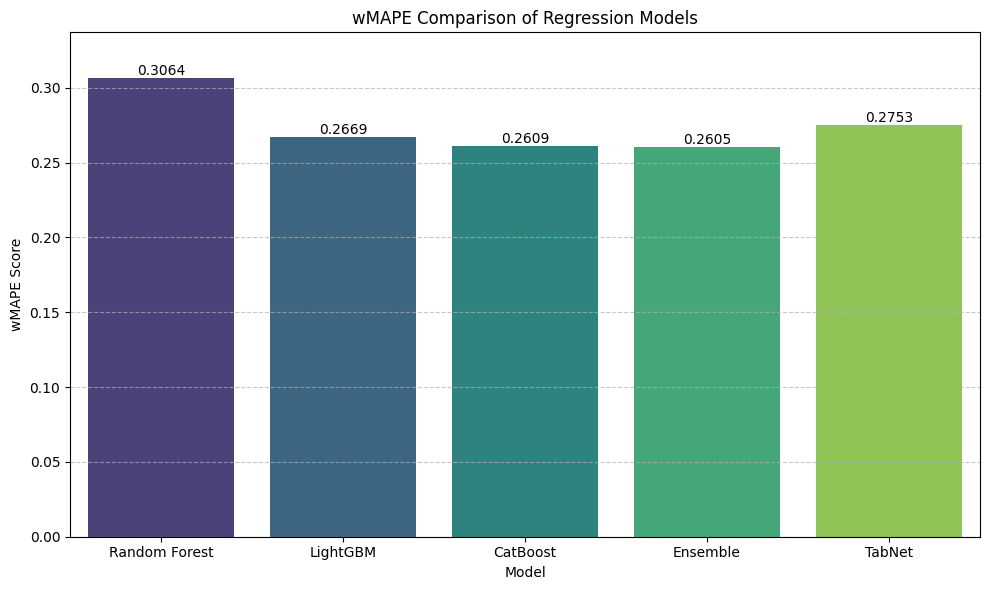

In [23]:
# Create a DataFrame to hold the wMAPE scores
model_names = ['Random Forest', 'LightGBM', 'CatBoost', 'Ensemble', 'TabNet']
wmape_scores = [
    w_mape_test,
    w_mape_test_lgbm,
    w_mape_test_cb,
    ensemble_wmape,
    tabnet_wmape
]

comparison_df = pd.DataFrame({
    'Model': model_names,
    'wMAPE': wmape_scores
})

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='wMAPE', data=comparison_df, palette='viridis')
plt.title('wMAPE Comparison of Regression Models')
plt.xlabel('Model')
plt.ylabel('wMAPE Score')
plt.ylim(0, max(comparison_df['wMAPE']) * 1.1) # Set y-axis limit to give some space above the highest bar

# Add wMAPE values on top of the bars
for index, row in comparison_df.iterrows():
    plt.text(index, row['wMAPE'], f"{row['wMAPE']:.4f}", color='black', ha="center", va='bottom')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Final Submission

In [24]:
# Store 'survey_id' and 'hhid' from submission_features for the final submission file
submission_id_df = submission_features[id_cols].copy()

# Drop 'survey_id' and 'hhid' from submission_features before preprocessing
submission_features_for_preprocessing = submission_features.drop(columns=id_cols)

# Preprocess the submission features using the fitted preprocessor
X_submission_processed = preprocessor.transform(submission_features_for_preprocessing)

# Remove the 'weight' column from the preprocessed submission features
submission_df = np.delete(X_submission_processed, weight_idx, axis=1)


print(f"Shape of X_submission_processed (before dropping weight): {X_submission_processed.shape}")
print(f"Shape of final_submission_features (after dropping weight): {submission_df.shape}")

Shape of X_submission_processed (before dropping weight): (103023, 182)
Shape of final_submission_features (after dropping weight): (103023, 181)


In [25]:
# Store 'survey_id' and 'hhid' from submission_features for the final submission file
submission_id_df = submission_features[id_cols].copy()

# Drop 'survey_id' and 'hhid' from submission_features before preprocessing
submission_features_for_preprocessing = submission_features.drop(columns=id_cols)

X_submission_processed_array_cb = preprocessor_cb.transform(submission_features_for_preprocessing)
submission_df_cb = pd.DataFrame(X_submission_processed_array_cb, columns=all_processed_feature_names, index=submission_features_for_preprocessing.index)

print(submission_df_cb.shape)
# Cast categorical columns to int
for col_name in cat_feature_names_out:
    submission_df_cb[col_name] = submission_df_cb[col_name].astype(int)

submission_fit_cb = submission_df_cb.drop(columns=[weight_col_name])

submission_pool_cb = Pool(
    data=submission_fit_cb,
    cat_features=cat_indices
)

final_preds_lgbm_log = model_lgbm.predict(submission_df)
final_preds_cb_log = model_cb.predict(submission_pool_cb)

final_preds_lgbm = np.expm1(final_preds_lgbm_log)
final_preds_cb = np.expm1(final_preds_cb_log)
final_test_preds_ensemble = (best_alpha * final_preds_cb) + ((1 - best_alpha) * final_preds_lgbm)


(103023, 86)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [26]:
final_test_preds = np.expm1(model.predict(submission_df))
print("Final predictions for X_test are ready.")

print(final_test_preds.shape)

Final predictions for X_test are ready.
(103023,)


In [27]:
poverty_lines = np.array([
    3.17, 3.94, 4.60, 5.26, 5.88, 6.47, 7.06,
    7.70, 8.40, 9.13, 9.87, 10.70, 11.62,
    12.69, 14.03, 15.64, 17.76, 20.99, 27.37
])

In [28]:
# Create a DataFrame for submission with survey_id, hhid, and predicted consumption
hh_df = submission_id_df.copy()
hh_df['cons_ppp17'] = final_test_preds_ensemble


hh_df.to_csv(
    'predicted_household_consumption.csv',
    index=False
)

print(hh_df.shape)

(103023, 3)


In [29]:
poverty_rows = []

hh_df['weight'] = submission_features_for_preprocessing['weight'].values

# Group by 'survey_id' from the pred_hh DataFrame, which now contains weights and predictions
for survey_id, df_s in hh_df.groupby('survey_id'):

    weights = df_s['weight'].values
    cons = df_s['cons_ppp17'].values

    weight_sum = weights.sum()

    for z in poverty_lines:
        poverty_rate = np.sum(weights * (cons < z)) / weight_sum

        poverty_rows.append({
            'survey_id': survey_id,
            'poverty_line': z,
            'poverty_rate': poverty_rate
        })

poverty_df = pd.DataFrame(poverty_rows)

# Pivot the DataFrame to have poverty lines as columns
poverty_df_pivot = poverty_df.pivot_table(
    index='survey_id',
    columns='poverty_line',
    values='poverty_rate'
)

# Rename columns to the desired format: 'pct_hh_below_X.YY'
poverty_df_pivot.columns = [f'pct_hh_below_{c:.2f}' for c in poverty_df_pivot.columns]

# Reset index to make survey_id a regular column again
poverty_df_pivot = poverty_df_pivot.reset_index()

poverty_df_pivot.to_csv(
    'predicted_poverty_distribution.csv',
    index=False
)

print(poverty_df_pivot.head())

   survey_id  pct_hh_below_3.17  pct_hh_below_3.94  pct_hh_below_4.60  \
0     400000           0.021940           0.059328           0.103645   
1     500000           0.014155           0.046554           0.091336   
2     600000           0.017557           0.050832           0.091200   

   pct_hh_below_5.26  pct_hh_below_5.88  pct_hh_below_6.47  pct_hh_below_7.06  \
0           0.154683           0.203803           0.253125           0.299929   
1           0.142097           0.192377           0.244888           0.296942   
2           0.138273           0.183994           0.232854           0.284473   

   pct_hh_below_7.70  pct_hh_below_8.40  pct_hh_below_9.13  pct_hh_below_9.87  \
0           0.359950           0.418522           0.481963           0.538643   
1           0.353033           0.414024           0.475086           0.534772   
2           0.341836           0.403985           0.470621           0.524474   

   pct_hh_below_10.70  pct_hh_below_11.62  pct_hh_below_1

In [30]:
import zipfile

with zipfile.ZipFile('submission.zip', 'w') as z:
    z.write('predicted_household_consumption.csv')
    z.write('predicted_poverty_distribution.csv')